In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import pandas_profiling 
from datetime import datetime

In [181]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
import statsmodels.api as sm

In [4]:
### Notebook configuration settings
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 5000
pd.options.display.float_format = '{:.3f}'.format
import warnings
warnings.filterwarnings('ignore')

### Reading train.csv,test.csv,features.csv and stores.csv

In [42]:
train = pd.read_csv('data/train.csv')

In [43]:
test = pd.read_csv('data/test.csv')

In [44]:
stores = pd.read_csv('data/stores.csv')

In [45]:
features = pd.read_csv('data/features.csv')

In [203]:
# For Output_excel file...
writer=pd.ExcelWriter('Walmart Store Sales Prediction output.xlsx', engine='xlsxwriter')

In [47]:
stores.head(2)

,Store,Type,Size
0,1,A,151315
1,2,A,202307


In [48]:
features.head(2)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.310,2.572,nan,nan,nan,nan,nan,211.096,8.106,False
1,1,2010-02-12,38.510,2.548,nan,nan,nan,nan,nan,211.242,8.106,True


In [49]:
train.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.500,False
1,1,1,2010-02-12,46039.490,True


In [50]:
test.head(2)

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False


### Merging of 3 files to build final train and test sales data

#### Train

In [54]:
train_int = pd.merge(train,stores) 
train = pd.merge(train_int,features)
#
test_int = pd.merge(test,stores)
test= pd.merge(test_int,features)

In [55]:
train.count()

Store           421570
Dept            421570
Date            421570
Weekly_Sales    421570
IsHoliday       421570
Type            421570
Size            421570
Temperature     421570
Fuel_Price      421570
MarkDown1       150681
MarkDown2       111248
MarkDown3       137091
MarkDown4       134967
MarkDown5       151432
CPI             421570
Unemployment    421570
dtype: int64

In [56]:
train.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.500,False,A,151315,42.310,2.572,nan,nan,nan,nan,nan,211.096,8.106
1,1,2,2010-02-05,50605.270,False,A,151315,42.310,2.572,nan,nan,nan,nan,nan,211.096,8.106


#### Test

In [57]:
test.count()

Store           115064
Dept            115064
Date            115064
IsHoliday       115064
Type            115064
Size            115064
Temperature     115064
Fuel_Price      115064
MarkDown1       114915
MarkDown2        86437
MarkDown3       105235
MarkDown4       102176
MarkDown5       115064
CPI              76902
Unemployment     76902
dtype: int64

In [58]:
test.head(2)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.320,3.386,6766.440,5147.700,50.820,3639.900,2737.420,223.463,6.573
1,1,2,2012-11-02,False,A,151315,55.320,3.386,6766.440,5147.700,50.820,3639.900,2737.420,223.463,6.573


### Numerical and categorical variables

#### Train

In [59]:
numeric_var_train=[key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_train=[key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ['object']]


In [60]:
# Train Numerical Data
train_num=train[numeric_var_train]

In [61]:
# Train Categorical Data
train_cat=train[cat_var_train]


In [65]:
print(f"Numerical Train Variables : {numeric_var_train}")
print("-----------------------------------------------------------")
print(f"Categorical Train Variables : {cat_var_train}")

Numerical Train Variables : ['Store', 'Dept', 'Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']
-----------------------------------------------------------
Categorical Train Variables : ['Date', 'Type']


#### Test

In [66]:
numeric_var_test=[key for key in dict(test.dtypes) if dict(test.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_test=[key for key in dict(test.dtypes) if dict(test.dtypes)[key] in ['object']]


In [67]:
# Train Numerical Data
test_num=test[numeric_var_test]

In [68]:
# Train Categorical Data
test_cat=test[cat_var_test]


In [69]:
print(f"Numerical Test Variables : {numeric_var_test}")
print("-----------------------------------------------------------")
print(f"Categorical Test Variables : {cat_var_test}")

Numerical Test Variables : ['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']
-----------------------------------------------------------
Categorical Test Variables : ['Date', 'Type']


### Data Audit report

#### Train

In [204]:
#### Numerical variables Audit report   
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])
 
num_summary=train_num.apply(lambda x: var_summary(x)).T
num_summary.to_excel(writer,'Numeric_variable Audit Summary',index=True)

num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Store,421570.000,0.000,9359084.000,22.201,22.000,12.785,163.464,1.000,1.000,3.000,5.000,11.000,22.000,33.000,40.000,43.000,45.000,45.000
Dept,421570.000,0.000,18658822.000,44.260,37.000,30.492,929.765,1.000,1.000,4.000,7.000,18.000,37.000,74.000,92.000,95.000,98.000,99.000
Weekly_Sales,421570.000,0.000,6737218987.110,15981.258,7612.030,22711.184,515797856.841,-4988.940,5.000,59.975,291.097,2079.650,7612.030,20205.853,42845.673,61201.951,106479.586,693099.360
Size,421570.000,0.000,57640387438.000,136727.916,140167.000,60980.583,3718631543.036,34875.000,34875.000,39690.000,39910.000,93638.000,140167.000,202505.000,204184.000,206302.000,219622.000,219622.000
Temperature,421570.000,0.000,25332166.060,60.090,62.090,18.448,340.326,-2.060,18.300,27.310,33.980,46.680,62.090,74.280,83.580,87.270,92.810,100.140
Fuel_Price,421570.000,0.000,1416907.953,3.361,3.452,0.459,0.210,2.472,2.565,2.653,2.720,2.933,3.452,3.738,3.917,4.029,4.202,4.468
MarkDown1,150681.000,270889.000,1091897841.540,7246.420,5347.450,8291.221,68744351.400,0.270,17.760,149.190,375.200,2240.270,5347.450,9210.900,15282.470,21801.350,41524.030,88646.760
MarkDown2,111248.000,310322.000,370970764.840,3334.629,192.000,9475.357,89782396.445,-265.760,-0.990,1.950,6.980,41.600,192.000,1926.940,8549.740,16497.470,50366.600,104519.540
MarkDown3,137091.000,284479.000,197331716.980,1439.421,24.600,9623.078,92603635.781,-29.100,0.060,0.650,1.650,5.080,24.600,103.990,400.090,1059.900,63143.290,141630.610
MarkDown4,134967.000,286603.000,456616070.020,3383.168,1481.310,6292.384,39594096.792,0.220,3.970,28.760,108.710,504.220,1481.310,3595.040,7871.420,12645.960,35785.260,67474.850


In [64]:
#### Categorical variables Audit report   
def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

cat_summary=train_cat.apply(lambda x: cat_summary(x))
cat_summary

,Date,Type
N,421570,421570
NMISS,0,0
ColumnsNames,2011-12-23 3027 2011-11-25 3021 2011-12-...,A 215478 B 163495 C 42597 Name: Type...


#### Test

In [70]:
num_summary=test_num.apply(lambda x: var_summary(x)).T
num_summary.head()

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Store,115064.000,0.000,2558817.000,22.238,22.000,12.810,164.094,1.000,1.000,3.000,5.000,11.000,22.000,33.000,40.000,43.000,45.000,45.000
Dept,115064.000,0.000,5101883.000,44.340,37.000,30.656,939.815,1.000,1.000,4.000,7.000,18.000,37.000,74.000,92.000,95.000,98.000,99.000
Size,115064.000,0.000,15705970078.000,136497.689,140167.000,61106.926,3734056458.719,34875.000,34875.000,39690.000,39910.000,93638.000,140167.000,202505.000,204184.000,206302.000,219622.000,219622.000
Temperature,115064.000,0.000,6206759.720,53.942,54.470,18.724,350.594,-7.290,11.440,23.980,29.970,39.820,54.470,67.350,79.480,83.820,92.140,101.950
Fuel_Price,115064.000,0.000,412107.046,3.582,3.606,0.239,0.057,2.872,2.957,3.161,3.227,3.431,3.606,3.766,3.866,3.951,4.079,4.125


In [71]:
def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

cat_summary=test_cat.apply(lambda x: cat_summary(x))
cat_summary

,Date,Type
N,115064,115064
NMISS,0,0
ColumnsNames,2012-12-21 3002 2012-12-07 2989 2012-12-...,"A 58713 B 44500 C 11851 Name: Type, d..."


### Pandas Profiling

#### Train

In [75]:
pandas_profiling.ProfileReport(train)

Number of variables,16
Number of observations,421570
Total Missing (%),21.1%
Total size in memory,51.9 MiB
Average record size in memory,129.0 B
Numeric,13
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,0


#### Test

In [76]:
pandas_profiling.ProfileReport(test)

Number of variables,15
Number of observations,115064
Total Missing (%),7.4%
Total size in memory,13.3 MiB
Average record size in memory,121.0 B
Numeric,12
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,0


### Correlation

#### Train

In [205]:
train_corr=pd.DataFrame(train.corr())
#train_corr.to_excel(writer,'Train_Data_Corr',index=True)
train_corr.to_excel(writer, sheet_name='Train_Data_Corr')

train_corr.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Date_dayofweek,Date_month,Date_year,Date_day
Store,1.000,0.024,-0.084,-0.001,0.226,-0.183,-0.050,0.065,-0.060,-0.034,-0.020,-0.043,nan,0.001,0.003,-0.000
Dept,0.024,1.000,0.141,0.001,0.004,-0.003,0.004,0.004,0.001,0.001,0.001,0.002,nan,0.001,0.004,-0.001
Weekly_Sales,-0.084,0.141,1.000,0.008,-0.189,0.253,0.001,0.001,0.050,0.022,0.029,0.039,nan,0.026,-0.009,-0.008
IsHoliday,-0.001,0.001,0.008,1.000,-0.001,0.001,-0.156,-0.078,-0.004,0.208,0.266,0.012,nan,0.123,-0.057,0.045
Type,0.226,0.004,-0.189,-0.001,1.000,-0.812,0.043,0.030,-0.126,-0.055,-0.024,-0.090,nan,-0.000,0.004,0.000


#### Test

In [78]:
test_corr=pd.DataFrame(test.corr())
test_corr.head()

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Store,1.000,0.020,-0.001,-0.187,-0.043,0.153,-0.092,-0.041,-0.025,0.010,0.010,-0.215,0.250
Dept,0.020,1.000,0.001,0.002,0.004,0.001,-0.002,0.001,0.000,0.003,0.001,-0.006,0.004
IsHoliday,-0.001,0.001,1.000,-0.000,-0.187,-0.126,0.355,0.265,0.496,0.290,-0.019,-0.001,0.010
Size,-0.187,0.002,-0.000,1.000,-0.061,0.055,0.310,0.158,0.050,0.155,0.104,-0.003,-0.002
Temperature,-0.043,0.004,-0.187,-0.061,1.000,0.074,-0.169,-0.324,-0.050,-0.060,0.004,0.281,0.022


### Visualization 

#### Train

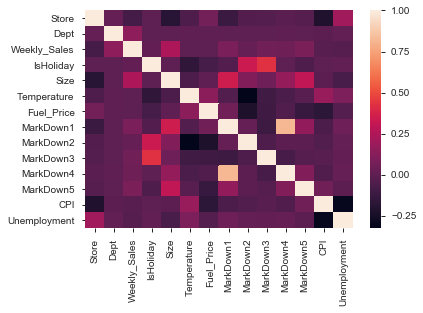

In [82]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(train.corr())

- This implies that Markdowns are highly correlated in train data

#### Test

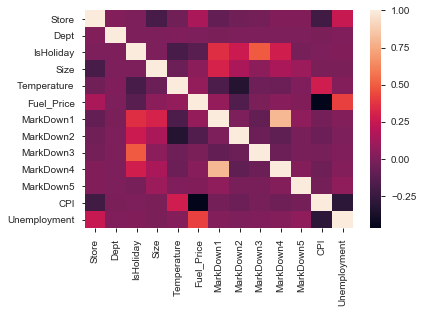

In [83]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(test.corr())

- This implies that Markdown4 is highly correlated to Markdown1 in test data

### Data Exploratory analysis

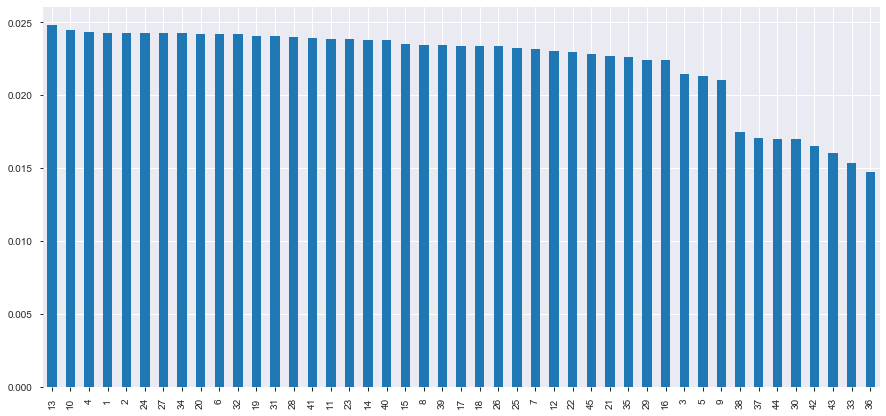

In [96]:
train['Store'].value_counts(normalize=True).plot(kind = 'bar',figsize=(15,7))

- This implies that Store 13 has maximum and Store 36 has least stores

In [102]:
plt.figure(figsize=(15,8))

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

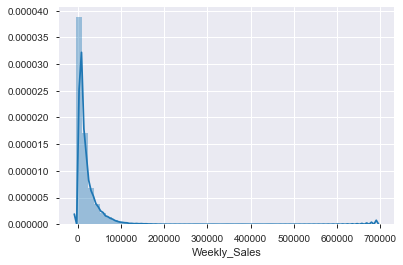

In [103]:
sns.distplot(train.Weekly_Sales)

#### Store Size vs Sales

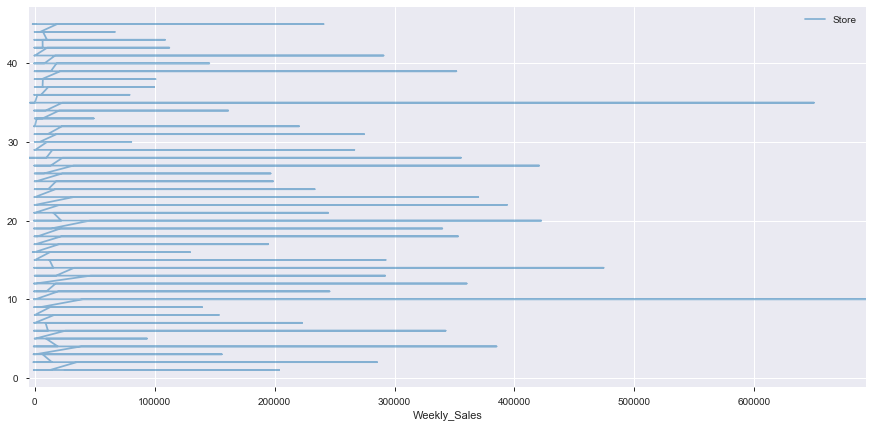

In [105]:
train.plot(kind='line', x='Weekly_Sales', y='Store', alpha=0.5,figsize=(15,7))

- This graph shows that store 10 has done highest sales

#### Sales vs Type

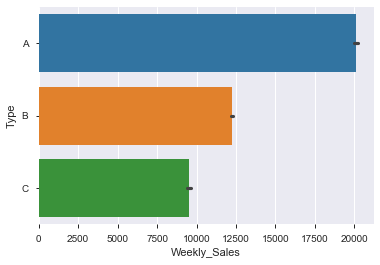

In [106]:
#tips = sns.load_dataset('train')
sns.barplot(x=train["Weekly_Sales"],y=train["Type"])

- This shows that TYPE A stores has done highest sales and TYPE C stores has done least sales

#### Sales vs Deptartment

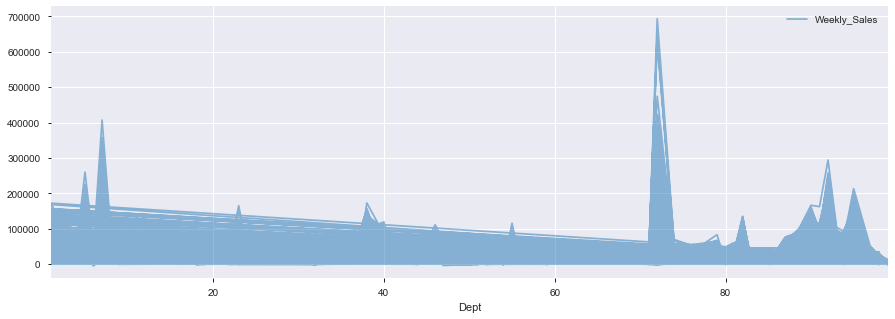

In [110]:
train.plot(kind='line', x='Dept', y='Weekly_Sales', alpha=1.5,figsize=(15,5))

- This shows that highest department sales lies between 60 and 80 department.

### Imputation

#### Train

In [112]:
train.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64

#### Test

In [113]:
test.isnull().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
dtype: int64

In [114]:
#### Mean Imputation
test['CPI']=test.groupby(['Dept'])['CPI'].transform(lambda x: x.fillna(x.mean()))
test['Unemployment']=test.groupby(['Dept'])['Unemployment'].transform(lambda x: x.fillna(x.mean()))

In [115]:
#### Missing values is imputated with zeros
train=train.fillna(0)
test=test.fillna(0)

#### Check if missing values has been imputated


#### Train

In [116]:
train.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64

#### Test

In [117]:
test.isnull().sum()

Store           0
Dept            0
Date            0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64

### Outlier treatment

In [118]:
train.Weekly_Sales=np.where(train.Weekly_Sales>100000, 100000,train.Weekly_Sales)

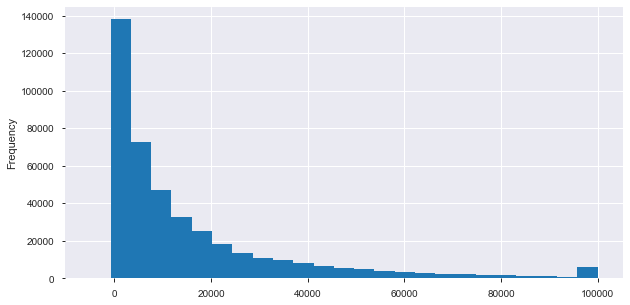

In [122]:

train.Weekly_Sales.plot.hist(bins=25,figsize=(10,5))

### Feature extraction and creation of extra features based on existing features

In [123]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       421570 non-null float64
MarkDown2       421570 non-null float64
MarkDown3       421570 non-null float64
MarkDown4       421570 non-null float64
MarkDown5       421570 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 71.9+ MB


In [124]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [125]:
# Extract date features
train['Date_dayofweek'] =train['Date'].dt.dayofweek
train['Date_month'] =train['Date'].dt.month 
train['Date_year'] =train['Date'].dt.year
train['Date_day'] =train['Date'].dt.day 

test['Date_dayofweek'] =test['Date'].dt.dayofweek
test['Date_month'] =test['Date'].dt.month 
test['Date_year'] =test['Date'].dt.year
test['Date_day'] =test['Date'].dt.day 

In [127]:
print('Train Type Value Counts')
print('*'*30)
train.Type.value_counts()

Train Type Value Counts
******************************


A    215478
B    163495
C     42597
Name: Type, dtype: int64

In [129]:
print('Test Type Value Counts')
print('*'*30)
test.Type.value_counts()

Test Type Value Counts
******************************


A    58713
B    44500
C    11851
Name: Type, dtype: int64

In [130]:
print('Train IsHoliday Counts')
print('*'*30)
train.IsHoliday.value_counts()

Train IsHoliday Counts
******************************


False    391909
True      29661
Name: IsHoliday, dtype: int64

In [131]:
print('Test IsHoliday Counts')
print('*'*30)
test.IsHoliday.value_counts()

Test IsHoliday Counts
******************************


False    106136
True       8928
Name: IsHoliday, dtype: int64

In [132]:
train_test_data = [train, test]

#### Conversion of categorical variable into numerical variable 

#### 1) Type variable : A=1, B=2 , C=3

In [135]:
type_mapping = {"A": 1, "B": 2, "C": 3}
for dataset in train_test_data:
    dataset['Type'] = dataset['Type'].map(type_mapping)

#### 2) IsHoliday variable

In [136]:
type_mapping = {False: 0, True: 1}
for dataset in train_test_data:
    dataset['IsHoliday'] = dataset['IsHoliday'].map(type_mapping)

#### Creation of additional Holiday Variable.
####  If that week comes under additional holiday then 1(=Yes) else 2(=No)

##### Train

In [139]:
train['Super_Bowl'] = np.where((train['Date']==datetime(2010, 2, 12)) | (train['Date']==datetime(2011, 2, 11)) | (train['Date']==datetime(2012, 2, 10)) | (train['Date']==datetime(2013, 2, 8)),1,0)
train['Labour_Day'] = np.where((train['Date']==datetime(2010, 9, 10)) | (train['Date']==datetime(2011, 9, 9)) | (train['Date']==datetime(2012, 9, 7)) | (train['Date']==datetime(2013, 9, 6)),1,0)
train['Thanksgiving'] = np.where((train['Date']==datetime(2010, 11, 26)) | (train['Date']==datetime(2011, 11, 25)) | (train['Date']==datetime(2012, 11, 23)) | (train['Date']==datetime(2013, 11, 29)),1,0)
train['Christmas'] = np.where((train['Date']==datetime(2010, 12, 31)) | (train['Date']==datetime(2011, 12, 30)) | (train['Date']==datetime(2012, 12, 28)) | (train['Date']==datetime(2013, 12, 27)),1,0)


##### Test

In [140]:

test['Super_Bowl'] = np.where((test['Date']==datetime(2010, 2, 12)) | (test['Date']==datetime(2011, 2, 11)) | (test['Date']==datetime(2012, 2, 10)) | (test['Date']==datetime(2013, 2, 8)),1,0)
test['Labour_Day'] = np.where((test['Date']==datetime(2010, 9, 10)) | (test['Date']==datetime(2011, 9, 9)) | (test['Date']==datetime(2012, 9, 7)) | (test['Date']==datetime(2013, 9, 6)),1,0)
test['Thanksgiving'] = np.where((test['Date']==datetime(2010, 11, 26)) | (test['Date']==datetime(2011, 11, 25)) | (test['Date']==datetime(2012, 11, 23)) | (test['Date']==datetime(2013, 11, 29)),1,0)
test['Christmas'] = np.where((test['Date']==datetime(2010, 12, 31)) | (test['Date']==datetime(2011, 12, 30)) | (test['Date']==datetime(2012, 12, 28)) | (test['Date']==datetime(2013, 12, 27)),1,0)


#### Train and Test

In [141]:
# Altering the isHoliday value depending on these new holidays...
train['IsHoliday']=train['IsHoliday']|train['Super_Bowl']|train['Labour_Day']|train['Thanksgiving']|train['Christmas']
test['IsHoliday']=test['IsHoliday']|test['Super_Bowl']|test['Labour_Day']|test['Thanksgiving']|test['Christmas']

#### Train

In [156]:
print("Christmas")
print("*"*30)
train.Christmas.value_counts()




Christmas
******************************


0    415624
1      5946
Name: Christmas, dtype: int64

In [157]:
print("Super_Bowl")
print("*"*30)
train.Super_Bowl.value_counts()


Super_Bowl
******************************


0    412675
1      8895
Name: Super_Bowl, dtype: int64

In [158]:
print("Thanksgiving")
print("*"*30)
train.Thanksgiving.value_counts()



Thanksgiving
******************************


0    415611
1      5959
Name: Thanksgiving, dtype: int64

In [159]:
print("Labour_Day")
print("*"*30)
train.Labour_Day.value_counts()


Labour_Day
******************************


0    412709
1      8861
Name: Labour_Day, dtype: int64

#### Test

In [164]:
print("Christmas")
print("*"*30)
test.Christmas.value_counts()

Christmas
******************************


0    112076
1      2988
Name: Christmas, dtype: int64

In [165]:
print("Super_Bowl")
print("*"*30)
test.Super_Bowl.value_counts()

Super_Bowl
******************************


0    112100
1      2964
Name: Super_Bowl, dtype: int64

In [166]:
print("Thanksgiving")
print("*"*30)
test.Thanksgiving.value_counts()


Thanksgiving
******************************


0    112088
1      2976
Name: Thanksgiving, dtype: int64

In [167]:
print("Labour_Day")
print("*"*30)
test.Labour_Day.value_counts()


Labour_Day
******************************


0    115064
Name: Labour_Day, dtype: int64

In [168]:
# Since we have Imputed IsHoliday according to Extra holidays..These extra holiday variable has redundant..
# Droping the Extra holiday variables because its redundant..
dp=['Super_Bowl','Labour_Day','Thanksgiving','Christmas']
train.drop(dp,axis=1,inplace=True)
test.drop(dp,axis=1,inplace=True)

### Feature Selection

In [170]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 20 columns):
Store             421570 non-null int64
Dept              421570 non-null int64
Date              421570 non-null datetime64[ns]
Weekly_Sales      421570 non-null float64
IsHoliday         421570 non-null int64
Type              421570 non-null int64
Size              421570 non-null int64
Temperature       421570 non-null float64
Fuel_Price        421570 non-null float64
MarkDown1         421570 non-null float64
MarkDown2         421570 non-null float64
MarkDown3         421570 non-null float64
MarkDown4         421570 non-null float64
MarkDown5         421570 non-null float64
CPI               421570 non-null float64
Unemployment      421570 non-null float64
Date_dayofweek    421570 non-null int64
Date_month        421570 non-null int64
Date_year         421570 non-null int64
Date_day          421570 non-null int64
dtypes: datetime64[ns](1), float64(10), int64(9)
memory usag

Dropping variables

- Since we have imputed markdown variables therefore we will not be removing the all markdown variables.
- Removing MarkDown5 because its Highly Skewed

In [171]:
features_drop=['Unemployment','CPI','MarkDown5']
train=train.drop(features_drop, axis=1)
test=test.drop(features_drop, axis=1)

In [172]:
train.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Date_dayofweek,Date_month,Date_year,Date_day
0,1,1,2010-02-05,24924.500,0,1,151315,42.310,2.572,0.000,0.000,0.000,0.000,4,2,2010,5
1,1,2,2010-02-05,50605.270,0,1,151315,42.310,2.572,0.000,0.000,0.000,0.000,4,2,2010,5


In [173]:
test.head(2)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Date_dayofweek,Date_month,Date_year,Date_day
0,1,1,2012-11-02,0,1,151315,55.320,3.386,6766.440,5147.700,50.820,3639.900,4,11,2012,2
1,1,2,2012-11-02,0,1,151315,55.320,3.386,6766.440,5147.700,50.820,3639.900,4,11,2012,2


### Model Accuracy

#### Split into train X ,train Y

In [175]:
#### train X= Include all variables except weekly sales
train_X=train.drop(['Weekly_Sales','Date'], axis=1)

#### train Y= Weekly_Sales 
train_y=train['Weekly_Sales']


#### Split into test X , test Y 

In [176]:

test_X=test.drop('Date',axis=1).copy()


In [177]:

train_X.shape, train_y.shape, test_X.shape

((421570, 15), (421570,), (115064, 15))

### Building models & comparing their RMSE values

#### Linear Regression

In [182]:
clf = LinearRegression()
clf.fit(train_X, train_y)
y_pred_linear=clf.predict(test_X)
acc_linear=round( clf.score(train_X, train_y) * 100, 2)
print ('scorbe:'+str(acc_linear) + ' percent')

scorbe:8.86 percent


#### Random Forest

In [183]:
clf = RandomForestRegressor(n_estimators=100)
clf.fit(train_X, train_y)
y_pred_rf=clf.predict(test_X)
acc_rf= round(clf.score(train_X, train_y) * 100, 2)
print ("Accuracy: %i %% \n"%acc_rf)

Accuracy: 99 % 



#### Decision Tree

In [184]:
clf=DecisionTreeRegressor()
clf.fit(train_X, train_y)
y_pred_dt= clf.predict(test_X)
acc_dt = round( clf.score(train_X, train_y) * 100, 2)
print (str(acc_dt) + ' percent')

100.0 percent


### Models comparison using accuracy score

In [185]:
models = pd.DataFrame({
    'Model': ['Linear Regression','Random Forest','Decision Tree'],
    
    'Score': [acc_linear, acc_rf,acc_dt]
    })

models.sort_values(by='Score', ascending=False)

,Model,Score
2,Decision Tree,100.000
1,Random Forest,99.770
0,Linear Regression,8.860


### Prediction

#### Test data Predicting Sales value using highest accuracy model

In [206]:
# Prediction value using Random Forest model..
final_pred = pd.DataFrame({
        "Store_Dept_Date": test.Store.astype(str)+'_'+test.Dept.astype(str)+'_'+test.Date.astype(str),
        "Weekly_Sales": y_pred_rf
    })

final_pred.to_csv('Predicted_Walmart_weekly_sales.csv', index=False)
final_pred.to_excel(writer,'Predicted_Weekly_sales',index=False)
writer.save()

In [187]:
final_pred.head()

,Store_Dept_Date,Weekly_Sales
0,1_1_2012-11-02,33621.081
1,1_2_2012-11-02,47105.276
2,1_3_2012-11-02,10603.560
3,1_4_2012-11-02,38194.473
4,1_5_2012-11-02,32029.015
